In [1]:
import pandas as pd
import numpy as np
import yaml
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
import prince
import shap
import sklearn

from sklearn.base import BaseEstimator,TransformerMixin, ClassifierMixin
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold, GridSearchCV, RandomizedSearchCV, validation_curve
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, RobustScaler, OneHotEncoder, PolynomialFeatures, StandardScaler, SplineTransformer, KBinsDiscretizer
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report, roc_auc_score, f1_score, roc_curve, auc, recall_score, precision_recall_curve, make_scorer, confusion_matrix, ConfusionMatrixDisplay
from sklearn.kernel_approximation import Nystroem
from sklearn.feature_selection import SelectKBest, f_classif, RFE
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from sklearn.decomposition import PCA
from sklearn.inspection import permutation_importance
from sklearn.svm import LinearSVC 


from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from imblearn.metrics import classification_report_imbalanced

from prince import FAMD

from scipy.stats import chi2_contingency

from optuna.samplers import TPESampler

import joblib

c:\Users\dcons\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
print('The scikit-learn version is {}.'.format(sklearn.__version__))
print('The joblib version is {}.'.format(joblib.__version__))

The scikit-learn version is 1.4.1.post1.
The joblib version is 1.3.2.


In [2]:
file = open('../../../conf/global_conf.yml', 'r') 
conf = yaml.safe_load(file)
df = pd.read_csv(conf['local_data_path'] + "data_cleaned_final_sans_dummies.csv",index_col=0,low_memory=False)

In [3]:
print(df.shape)

(447136, 41)


In [4]:
# Recodage variable cible grav par ordre croissant : 0 : indemne, 1 : blessé léger, 2 : blessé grave, 3 : décès
with pd.option_context("future.no_silent_downcasting", True):
    df['grav'] = df['grav'].replace(1,'I')
    df['grav'] = df['grav'].replace(2,'T')
    df['grav'] = df['grav'].replace(3,'BG')
    df['grav'] = df['grav'].replace(4,'BL')
    df['grav'] = df['grav'].replace('I',0)
    df['grav'] = df['grav'].replace('T',3)
    df['grav'] = df['grav'].replace('BG',2)
    df['grav'] = df['grav'].replace('BL',1)

In [5]:
data = df.drop(['grav_rec', 'an', 'jour', 'date', 'dep', 'grav'], axis=1)
y = df.grav.astype('int')
numerical_features = ['age_usager', 'mois', 'heure', 'lat', 'long']
categorical_features = [col for col in data.columns if col not in numerical_features]
data[categorical_features] = data[categorical_features].astype('object')
#data.info()

In [6]:
data.head()

,mois,lum,agg,int,atm,col,lat,long,catr,circ,...,eq_ceinture,eq_casque,eq_siege,eq_gilet,eq_airbag,eq_gants,eq_indetermine,eq_autre,jour_chome,prox_pt_choc
0,11,2.0,0,0.0,0.0,2.0,48.896210,2.470120,1,0.0,...,1,0,0,0,0,0,0,0,1,0
1,11,2.0,0,0.0,0.0,2.0,48.896210,2.470120,1,0.0,...,1,0,0,0,0,0,0,0,1,0
2,11,2.0,0,0.0,0.0,2.0,48.896210,2.470120,1,0.0,...,1,0,0,0,0,0,0,0,1,1
3,11,2.0,0,0.0,0.0,6.0,48.930700,2.368800,1,0.0,...,1,0,0,0,0,0,0,0,1,1
4,11,0.0,0,0.0,0.0,4.0,48.935872,2.319174,1,0.0,...,1,0,0,0,0,0,0,0,1,1


In [7]:
data.shape

(447136, 35)

In [8]:
data_train, data_test, y_train, y_test = train_test_split(data, y, test_size=0.25, random_state=42, stratify=y)

In [9]:
class TransfoHour(BaseEstimator, TransformerMixin):
    def __init__(self, column_name):
        self.column_name = column_name
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X_transfo = X.copy()
        X_transfo[f'{self.column_name}_sin'] = np.sin(X_transfo[self.column_name]*(2.*np.pi/24))
        X_transfo[f'{self.column_name}_cos'] = np.cos(X_transfo[self.column_name]*(2.*np.pi/24))
        X_transfo = X_transfo.drop(self.column_name, axis=1)
        return X_transfo
    
    def get_feature_names_out(self):
        pass
    
class TransfoMonth(BaseEstimator, TransformerMixin):
    def __init__(self, column_name):
        self.column_name = column_name
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X_transfo = X.copy()
        X_transfo[f'{self.column_name}_sin'] = np.sin((X_transfo[self.column_name]-1)*(2.*np.pi/12))
        X_transfo[f'{self.column_name}_cos'] = np.cos((X_transfo[self.column_name]-1)*(2.*np.pi/12))
        X_transfo = X_transfo.drop(self.column_name, axis=1)
        return X_transfo

    def get_feature_names_out(self):
        pass
    

In [10]:
preprocessor = ColumnTransformer(transformers=[
    ("transfo_heure", TransfoHour('heure'), ['heure']),
    ("transfo_mois", TransfoMonth('mois'), ['mois']),
    ("transfo_lat_long", RobustScaler(), ['lat', 'long']),
    ('transfo_age_usager', MinMaxScaler(), ['age_usager']),
    ("one_hot_encoder", OneHotEncoder(handle_unknown="ignore", sparse_output=False), ['place_rec','catr', 'surf', 'infra', 'situ', 'motor', 'manv', 'obsm', 'catv', 'col', 'lum'])
    ],
    remainder="passthrough"
).set_output(transform="pandas")


In [11]:
svm = Pipeline(steps=[("preprocessor", preprocessor),
                      ("nystroem", Nystroem(degree=2, n_components=300)),
                      ("svm", LinearSVC(class_weight='balanced', loss="hinge", random_state=42))])

**Modèle de base**

In [12]:
f1 = make_scorer(f1_score, average='micro')
cv_results = cross_validate(svm, data, y, cv=3, 
                            return_estimator=True, return_train_score=True, scoring=f1,
                            n_jobs=-1, verbose=10)
cv_results = pd.DataFrame(cv_results)
cv_results

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  2.3min finished


,fit_time,score_time,estimator,test_score,train_score
0,105.378984,5.385535,"(ColumnTransformer(remainder='passthrough',\n ...",0.598909,0.596555
1,115.754321,5.764750,"(ColumnTransformer(remainder='passthrough',\n ...",0.599953,0.603121
2,109.182286,5.436755,"(ColumnTransformer(remainder='passthrough',\n ...",0.594787,0.601974


In [13]:
svm.named_steps['nystroem'].get_params(deep=False)

{'coef0': None,
 'degree': 2,
 'gamma': None,
 'kernel': 'rbf',
 'kernel_params': None,
 'n_components': 300,
 'n_jobs': None,
 'random_state': None}

In [14]:
svm.named_steps['svm'].get_params(deep=False)

{'C': 1.0,
 'class_weight': 'balanced',
 'dual': 'warn',
 'fit_intercept': True,
 'intercept_scaling': 1,
 'loss': 'hinge',
 'max_iter': 1000,
 'multi_class': 'ovr',
 'penalty': 'l2',
 'random_state': 42,
 'tol': 0.0001,
 'verbose': 0}

**Hyperparameter tuning**

**LinearSVC**

In [30]:
data__train, data__val, y__train, y__val = train_test_split(data_train, y_train, test_size=0.25, random_state=42, stratify=y_train)

In [31]:
preprocessor = ColumnTransformer(transformers=[
    ("transfo_heure", TransfoHour('heure'), ['heure']),
    ("transfo_mois", TransfoMonth('mois'), ['mois']),
    ("transfo_lat_long", RobustScaler(), ['lat', 'long']),
    ('transfo_age_usager', MinMaxScaler(), ['age_usager']),
    ("one_hot_encoder", OneHotEncoder(handle_unknown="ignore", sparse_output=False), ['place_rec','catr', 'surf', 'infra', 'situ', 'motor', 'manv', 'obsm', 'catv', 'col', 'lum'])
    ],
    remainder="passthrough"
).set_output(transform="pandas")


In [14]:
def objective(trial):
    params_nystroem = {
        'degree' : trial.suggest_int('degree', 2, 4),
        'n_components' : trial.suggest_int('n_components', 150, 450)
    }
    params_svm = {
        'penalty' : trial.suggest_categorical('penalty', ['l1', 'l2']),
        "C": trial.suggest_float("C", 0.05, 10.0),
        "multi_class" : trial.suggest_categorical('multi_class', ['ovr', 'crammer_singer']),
    }

    model = Pipeline(steps=[("preprocessor", preprocessor),
                      ("nystroem", Nystroem(**params_nystroem, random_state=1234)),
                      ("svm", LinearSVC(class_weight='balanced', **params_svm, dual=False, random_state=1234))])
    model.fit(data__train, y__train)
    y_pred = model.predict(data__val)
    cat_f1 = f1_score(y__val, y_pred, average = 'weighted')
    return cat_f1

sampler = TPESampler(seed=1234, multivariate=True, group=True)
study = optuna.create_study(direction='maximize', sampler=sampler)
study.optimize(objective, n_trials=20, n_jobs=-1)

c:\Users\dcons\anaconda3\Lib\site-packages\optuna\samplers\_tpe\sampler.py:319: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  warnings.warn(
c:\Users\dcons\anaconda3\Lib\site-packages\optuna\samplers\_tpe\sampler.py:330: ExperimentalWarning: ``group`` option is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2024-05-25 15:21:08,335] A new study created in memory with name: no-name-9263d84d-7498-48cb-a702-52b717a254dc
[I 2024-05-25 15:35:49,006] Trial 4 finished with value: 0.6208857294107138 and parameters: {'degree': 2, 'n_components': 314, 'penalty': 'l2', 'C': 2.6794657779772697, 'multi_class': 'ovr'}. Best is trial 4 with value: 0.6208857294107138.
[I 2024-05-25 15:35:53,932] Trial 5 finished with value: 0.6206444788058095 and parameters: {'degree': 2, 'n_components': 303, 'penalty': 'l2', 'C': 9.315698711725254, 'multi_class': 'ovr'}. Best is trial 4 with value: 0.620885729410

Influence des hyperparamètres sur la performance du modèle

In [15]:
optuna.visualization.plot_parallel_coordinate(study)

In [16]:
optuna.visualization.plot_param_importances(study)

In [17]:
study.best_params

{'degree': 2,
 'n_components': 436,
 'penalty': 'l2',
 'C': 1.2480028741569764,
 'multi_class': 'ovr'}

Entraînement du modèle avec les meilleurs hyperparamètres obtenus précédemment

In [32]:
svm = Pipeline(steps=[("preprocessor", preprocessor),
                      ("nystroem", Nystroem(degree=2, n_components=436, random_state=1234)),
                      ("svm", LinearSVC(class_weight='balanced', C=1.2480028741569764, multi_class='ovr', dual=False, random_state=1234))])
svm.fit(data_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('transfo_heure',
                                                  TransfoHour(column_name='heure'),
                                                  ['heure']),
                                                 ('transfo_mois',
                                                  TransfoMonth(column_name='mois'),
                                                  ['mois']),
                                                 ('transfo_lat_long',
                                                  RobustScaler(),
                                                  ['lat', 'long']),
                                                 ('transfo_age_usager',
                                                  MinMaxScaler(),
                                                  ['age_usager']),
                                                 ('one_hot_encoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['place_rec', 'catr', 'surf',
                                                   'infra', 'situ', 'motor',
                                                   'manv', 'obsm', 'catv',
                                                   'col', 'lum'])])),
                ('nystroem',
                 Nystroem(degree=2, n_components=436, random_state=1234)),
                ('svm',
                 LinearSVC(C=1.2480028741569764, class_weight='balanced',
                           dual=False, random_state=1234))])

Sauvegarde du modèle

In [33]:
filename = conf['local_data_path'] + 'svm_model'
joblib.dump(svm, filename)

['C:/Users/dcons/Documents/NADEGE/DATASCIENTEST/Projet/data/svm_model']

In [15]:
#Si besoin de recharger le modèle
filename = conf['local_data_path'] + 'svm_model'
svm = joblib.load(filename)

Analyse des prédictions avec ce modèle

In [13]:
score_train = svm.score(data_train, y_train)
score_test = svm.score(data_test, y_test)
print(f"Le score sur le jeu d'entraînement est de {score_train}, et de {score_test} sur le jeu de test.")

Le score sur le jeu d'entraînement est de 0.6248479209904817, et de 0.6242127674801403 sur le jeu de test.


In [16]:
y_pred = svm.predict(data_test)
cr= classification_report(y_test, y_pred, target_names=['0-Indemnes', '1-Blessés légers', '2-Blessés graves', '3-Tués'])
print(cr)

                  precision    recall  f1-score   support

      0-Indemnes       0.71      0.80      0.75     46137
1-Blessés légers       0.67      0.55      0.60     45097
2-Blessés graves       0.46      0.39      0.42     17500
          3-Tués       0.16      0.40      0.23      3050

        accuracy                           0.62    111784
       macro avg       0.50      0.54      0.50    111784
    weighted avg       0.64      0.62      0.63    111784



In [35]:
y_pred = svm.predict(data_test)
cr= classification_report(y_test, y_pred, target_names=['Indemnes', 'Blessés légers', 'Blessés graves', 'Tués'], output_dict=True)
df_cr = pd.DataFrame(cr).transpose()
print(df_cr)
df_cr.to_csv(conf['local_data_path'] + 'svm_report' + '.csv')

                precision    recall  f1-score        support
Indemnes         0.710526  0.802913  0.753900   46137.000000
Blessés légers   0.667261  0.547841  0.601683   45097.000000
Blessés graves   0.459445  0.388743  0.421147   17500.000000
Tués             0.156622  0.401311  0.225311    3050.000000
accuracy         0.624213  0.624213  0.624213       0.624213
macro avg        0.498463  0.535202  0.500510  111784.000000
weighted avg     0.638651  0.624213  0.625975  111784.000000


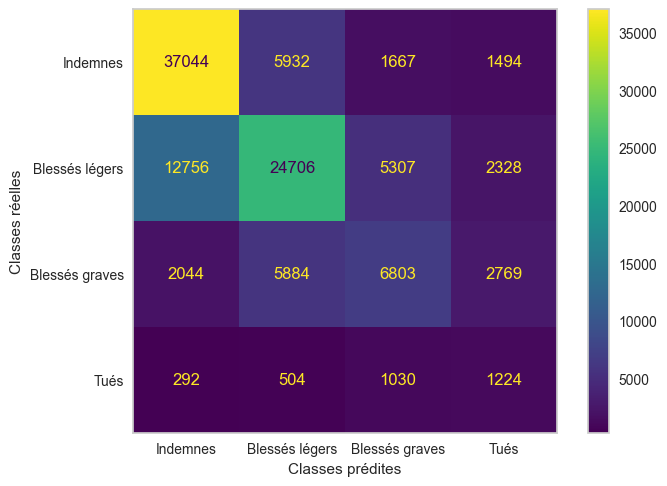

In [36]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay.from_estimator(
        svm,
        data_test,
        y_test,
        display_labels=['Indemnes', 'Blessés légers', 'Blessés graves', 'Tués']
    )
disp.ax_.set(xlabel='Classes prédites', ylabel='Classes réelles')
plt.grid(False)
plt.savefig(conf['local_data_path'] + 'svm_confusion_matrix' + '.jpg')

**Interprétabilité**

In [14]:
svm = Pipeline(steps=[("preprocessor", preprocessor),
                      ("nystroem", Nystroem(degree=2, n_components=436, random_state=1234)),
                      ("svm", LinearSVC(class_weight='balanced', C=1.2480028741569764, multi_class='ovr', dual=False, random_state=1234))])


In [15]:
f1 = make_scorer(f1_score, average='micro')
cv_results = cross_validate(svm, data, y, cv=3, 
                            return_estimator=True, return_train_score=True, scoring=f1,
                            verbose=10)
cv_results = pd.DataFrame(cv_results)
cv_results

[CV] START .....................................................................
[CV] END ..................., score=(train=0.625, test=0.628) total time= 6.3min
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:  6.5min


[CV] END ..................., score=(train=0.627, test=0.622) total time= 6.5min
[CV] START .....................................................................
[CV] END ..................., score=(train=0.628, test=0.619) total time= 6.3min


,fit_time,score_time,estimator,test_score,train_score
0,373.302557,4.501994,"(ColumnTransformer(remainder='passthrough',\n ...",0.628296,0.624821
1,383.377196,4.515608,"(ColumnTransformer(remainder='passthrough',\n ...",0.621732,0.627500
2,376.593535,4.474960,"(ColumnTransformer(remainder='passthrough',\n ...",0.618551,0.627781


<Axes: xlabel='0', ylabel='None'>

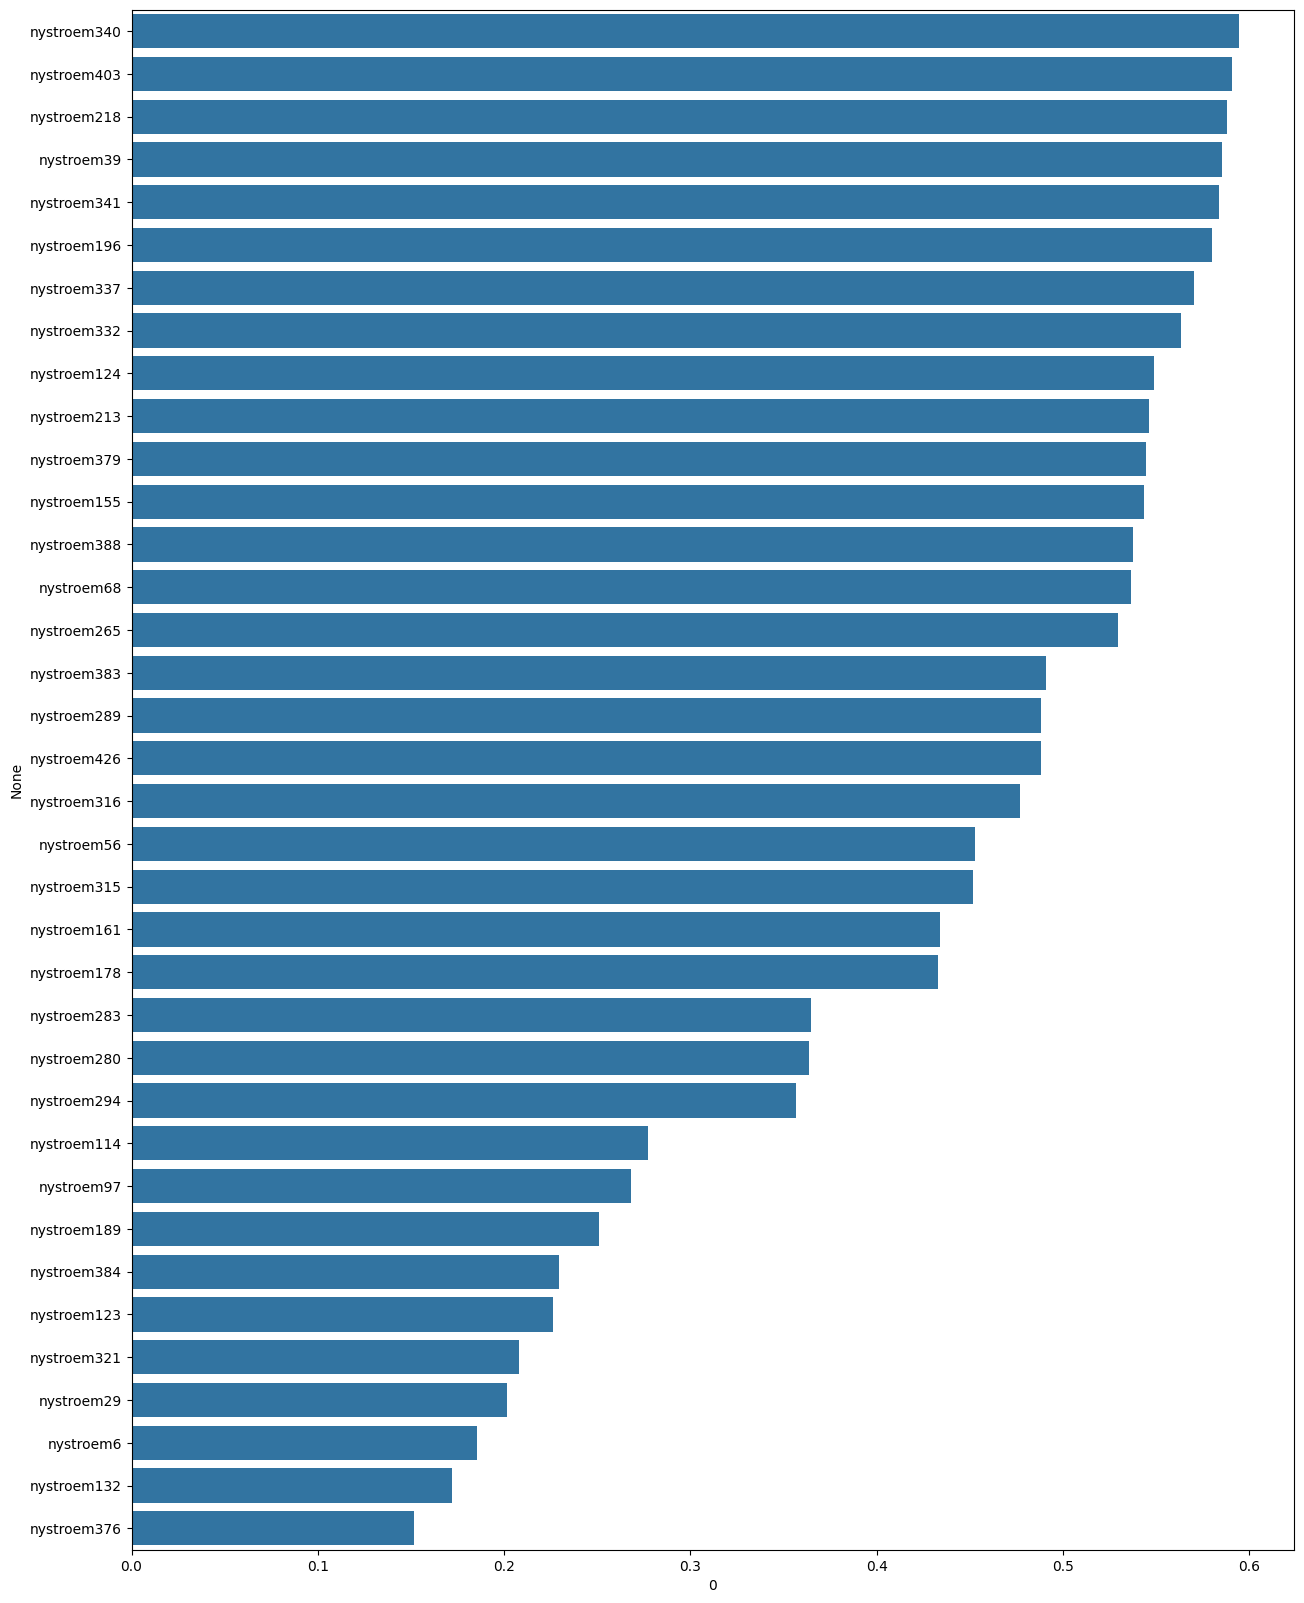

In [24]:
coefs = [est[-1].coef_[0] for est in cv_results["estimator"]]
weights_svm = pd.DataFrame(np.abs(coefs), columns = cv_results["estimator"][0].named_steps['nystroem'].get_feature_names_out())

class_weights = pd.DataFrame(weights_svm.mean()).sort_values(by=0, ascending=False)


plt.figure(figsize=(15,20));
sns.barplot(y=class_weights.index[400:500], x=0, data=class_weights[400:500])